# Initial Setup

## 1. Reading clinical trials & Patient cases

In [1]:
%reload_ext autoreload
%autoreload 2

import pprint
import loader as ld
from loadtrials import load_trials, load_queries, get_evaluator, LONG_QUERIES

pp = pprint.PrettyPrinter(width=120, compact=True)
queries = load_queries(LONG_QUERIES)

eval  = get_evaluator(queries)
ids, full_docs = ld.load(
    'docs',
    lambda: load_trials(eval)
)

## 2. Build the corposes

In [2]:
# setting up the corpus
import index

# from first phase c:
CHOSEN_LAMBDA = 0.2
def load_corpus():
    corpus = []
    for trial in full_docs:
        corpus.append(trial._detailed_description)

    return corpus

lmjm_full_text  = ld.load(
    'lmjm-full-text-model',
    lambda: index.LMJMindex(
            load_corpus(), _lambda=CHOSEN_LAMBDA
    )
)

## 3. Setting filtering methods

In [3]:
import re
import numpy as np  

# MIN_SCORE = -10 ** 6

# TODO: define a class query where this are defined as variables of each query
age_re    = re.compile(r'(\d+)\s?(-?(year|month)(-|\s)old|yo)')
young_re  = re.compile(r'young\s(adult\s)?(man|woman|men|women)', re.IGNORECASE)
adult_re  = re.compile(r'man|woman|men|women', re.IGNORECASE)
gender_re = re.compile(r'\b(male|female|man|his|her|woman|boy|girl|men|women)\b', re.IGNORECASE)

male_expression = ['male', 'man', 'boy', 'men', 'his']


MIN_VALUE = - 10 ** 6

def get_age(case):
    res = age_re.search(case)

    if res is None:
        # taken from: https://www.quora.com/At-what-age-does-a-female-turn-from-a-girl-to-a-lady-and-then-finally-a-woman
        # which is probably not the most trustable source ...
        case = case.lower()
        if young_re.search(case) != None:
            return 18
        if adult_re.search(case) != None:
            return 25
        return 0

    age_or_month = int(res.group(1))
    return age_or_month if res.group(3) != 'month' else age_or_month / 12

def get_gender(case):
    res = gender_re.findall(case)
    if len(res) == 0:
        return 'Both'

    # return res[0] if len(res) > 0 else 'both'
    return 'Male' if res[0].lower() in male_expression else 'Female'


# TODO; complete this function
def filter_by_age_and_gender(doc_scores, query):
    gender = get_gender(query)
    age    = get_age(query)

    # min_score = np.min(doc_scores) - 1
    for i in range(len(doc_scores)):
        doc_gender   = full_docs[i]._gender
        doc_max_age  = full_docs[i]._maximum_age
        doc_min_age  = full_docs[i]._minimum_age 
        if (doc_gender.lower() == 'both' or doc_gender == gender) \
            and doc_max_age >= age and doc_min_age <= age: continue
        doc_scores[i] = MIN_VALUE

    # TO DO: Implement filters by age and gender
    return doc_scores

## 4. Setting some metrics

In [4]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import trec
import index

from typing import Dict 

plt.rcParams['figure.figsize'] = [12, 6]

class Metrics:
    # where each row is a tuple of (docid, ap, p10, mrr, ndcg5, recall)
    def __init__(self, rows, precision):#m_ap, p10, mrr, ndcg5, recall):

        self.data = pd.DataFrame(
            rows, 
            columns = ['caseid', 'ap', 'p10', 'mrr', 'ndcg@5', 'recall@100', 'relevant-documents']
        )

        self.data.set_index('caseid', inplace=True)

        # for each query we have a tuple of (precision_11point, recall_11point, total_relv_ret)
        self.precision = precision
        self.recall    = trec.RECALL_11POINT

        res = self.data.mean()#.drop(columns=['caseid']).mean()
        self.m_ap    = res['ap']
        self.m_p10   = res['p10']
        self.m_mrr   = res['mrr']
        self.m_ndcg5 = res['ndcg@5']
        self.m_recall100 = res['recall@100']

        # self.mean_precision_11point = np.sum(list(precision.values())) / len(precision)
        self.mean_precision_11point = np.mean(precision, axis=0) #np.sum(list(precision.values())) / len(precision)

        confidence = 0.99
        std_deviasion = np.std(precision, axis=0)
        mean = self.mean_precision_11point #np.mean(values, axis=0)

        diff = confidence * (std_deviasion / np.sqrt(len(precision)))

        self.upper_precision = mean + diff
        self.lower_precision = mean - diff

    

    def plot_documents_precision(self, model='', filename=None):
        self.data.plot.scatter(
            x='relevant-documents',
            y='p10',
            # colormap='viridis',
        )

        _, top = plt.ylim()
        plt.ylim(0, top)
        plt.title(f'P10/relevant-documents relation by query (for model {model})')
        # plt.savefig(f'{model}-p10-relevant-documents.pdf')
        if filename is not None:
            plt.savefig(filename+ '.pdf')
            
        plt.show()


    def plot_precision_recall(self, model_name, filename=None):

        plt.plot(self.recall, self.mean_precision_11point)
        plt.title(f'Precision/Recall curve for {model_name}')
        plt.xlabel("Recall", fontweight='bold')
        plt.ylabel("Precision", fontweight='bold')

        _, top = plt.ylim()
        plt.ylim(0, top)

        plt.fill_between(
            self.recall, 
            self.lower_precision,
            self.upper_precision,
            alpha=0.2
        )

        if filename is not None:
            plt.savefig(filename+ '.pdf')
        plt.show()

    def plot_top_5p10_metrics(self, model_name, filename=None):
        aux = self.data.sort_values(
            by=['p10'], ascending = False
        ).drop(columns=['relevant-documents'])

        ax  = aux.head(5).plot(
            kind='bar'
        )

        for cnt in ax.containers:
            ax.bar_label(cnt, labels=[f"{round(v, 1)}" for v in cnt.datavalues])

        plt.title(f'Metrics for the first 5 queries ranked by P10 for model {model_name}')
        plt.xticks(rotation=0, horizontalalignment="center")
        plt.xlabel('Case Indentifier', fontweight='bold')

        # plt.savefig(f'{model_name}-top5-metrics.pdf')
        if filename is not None:
            plt.savefig(filename+ '.pdf')
        plt.show()


def compare_pecision_recall_models(metrics, filename=None):

    for model_name, m in metrics.items():
        plt.plot(m.recall, m.mean_precision_11point, label=model_name)

        plt.fill_between(
            m.recall, 
            m.lower_precision,
            m.upper_precision,
            alpha=0.2
        )

    _, top = plt.ylim()
    plt.ylim(0, top)
    plt.xlim(0, 1)
    plt.title(f'Precision/Recall curve for all the Models')
    plt.xlabel("Recall", fontweight='bold')
    plt.ylabel("Precision", fontweight='bold')

    plt.legend(title="Models")

    if filename is not None:
        plt.savefig(filename+ '.pdf')
    plt.show()

def calc_metrics_summary(metrics : Dict[str, Metrics]):

    rows = []
    for model_name, m in metrics.items():
        rows.append((model_name, m.m_ap, m.m_mrr, m.m_p10, m.m_ndcg5, m.m_recall100))

    metrics_summary = pd.DataFrame(
        rows,
        columns = ['model', 'MAP', 'MRR', 'P10', 'NDCG@5', 'Recall@100'],
    )

    metrics_summary.set_index('model', inplace=True)
    return metrics_summary


def plot_summary_metrics(metrics_summary : pd.DataFrame, decimal_case=2, filename=None):
    ax = metrics_summary.plot(
        kind='bar',
        figsize=(30, 8),
        width=0.8
    )

    for cnt in ax.containers:
        ax.bar_label(cnt, labels=[f"{round(v, decimal_case)}" for v in cnt.datavalues], fontsize=12)

    plt.xticks(rotation=0, horizontalalignment="center", fontsize=14)
    plt.xlabel('Models', fontweight='bold', fontdict={'fontsize': 15})
    plt.title('Performance of each one of the models', fontdict={'fontsize': 20})
    # plt.ylim(0, 0.5)
    plt.legend(title='Metrics', fontsize=15, title_fontsize=15)

    if filename is not None:
        plt.savefig(filename + '.pdf')
    plt.show()

def calc_ranking(search_index, query_info, filter=True) -> pd.DataFrame:
    caseid, query = query_info
    search_key    = caseid if isinstance(search_index, index.UltimateIndex) else query
    # if isinstance(search_index, index.UltimateIndex):
    #     print("executing ultimate index search with search-key: ", search_key)

    doc_scores    = search_index.search(search_key)
    if filter:
        doc_scores = filter_by_age_and_gender(doc_scores, query)

    results = pd.DataFrame(list(zip(ids, doc_scores)), columns = ['_id', 'score'])
    results_ord = results.sort_values(by=['score'], ascending = False)

    return results_ord

def calc_metrics(index, queries) -> Metrics:

    # simple metrics rows
    rows      = []
    precision = []

    for caseid, query in queries.items():
        # query = cases[caseid]
        # doc_scores = index.search(query)
        # doc_scores = filter_by_age_and_gender(doc_scores, query)

        # results = pd.DataFrame(list(zip(ids, doc_scores)), columns = ['_id', 'score'])
        # results_ord = results.sort_values(by=['score'], ascending = False)
        results_ord = calc_ranking(index, (caseid, query))

        [precision_11point, recall_11point, total_relv_ret] = eval.evalPR(results_ord, caseid)

        # precision[caseid] = precision_11point #, total_relv_ret)
        precision.append( precision_11point ) #, total_relv_ret)
        

        [p10, recall, ap, ndcg5, mrr] = eval.eval(results_ord, caseid)
        # add the precision at 11 points
        rows.append(
            (caseid, ap, p10, mrr, ndcg5, recall, total_relv_ret)
        )

    return Metrics(rows, precision)

def get_metrics(index, queries) -> pd.DataFrame:
    params = {}
    metrics_rows = []
    for lbd in np.arange(0, 1, 0.05):
        params['lambda'] = lbd
        index.set_params(params)
        m = calc_metrics(index, queries)
        metrics_rows.append((
            lbd, m.m_ap, m.m_p10, m.m_mrr, 
            m.m_ndcg5, m.m_recall100
        ))

    rows = pd.DataFrame(metrics_rows, columns = ['lambda', 'MAP', 'P10', 'MRR', 'NDCG@5', 'Recall@100'])
    return rows

def plot_lambdas_metrics(result : pd.DataFrame, title : str, choosen_lambda : float, filename=None):

    for metric in result.columns:
        plt.plot(
            result.index, 
            result[metric], 
            label=metric,
        )

    _, top = plt.ylim()
    plt.ylim(0, top)
    plt.xlim(0, 1)
    plt.axvline(x = choosen_lambda, color = 'red', linestyle = '--', alpha = 0.5)

    plt.title(title)
    plt.legend(title='Metrics')
    plt.xlabel('Lambda values', fontweight='bold')
    plt.xticks(result.index)

    if filename is not None:
        plt.savefig(filename+ '.pdf')
    plt.show()

# 5. Building query-docs pairs

## 5.1 Separating into train and test queries

In [5]:
lmjm_scores = ld.load(
    'lmjm_full_text_scores',
    lambda: dict( 
        [ (caseid, calc_ranking(lmjm_full_text, query, filter=False)) for caseid, query in queries.items()]
    ) 
) 

def get_train_and_test_queires(queries):
    queries_p10    = []

    for qid in queries:
        rank = lmjm_scores[qid]
        p10  = eval.eval(rank, qid)[0]
        queries_p10.append((qid, p10))

    queries_p10.sort(key=lambda x: x[1])
    queries_idx = [x[0] for x in queries_p10]

    test_sep  = round( 1 / 0.25 )

    test_data  = queries_idx[::test_sep]
    train_data = [x for x in queries_idx if x not in test_data]

    return train_data, test_data

train_queries, test_queries = ld.load( 
    'test-and-train-queires',
    lambda: get_train_and_test_queires(queries)
)

## 5.2 Generating pairs for train and test

In [10]:
def gen_query_doc_pairs(queries_ids):
    xx = []
    yy = []

    juddments = eval.relevance_judgments
    for quid in queries_ids:
        docs_rel = juddments[ 
            juddments['query_id'] == quid 
        ][['docid', 'rel']].itertuples(index=False)

        scored = set()
        for docid, rel in docs_rel:
            scored.add(docid)
            xx.append( (quid, docid))
            yy.append(rel)

        # add the hard negatives
        rank = lmjm_scores[quid]
        top  = rank.head( 100 )

        for docid in top['_id'].values:
            if not docid in scored:
                xx.append((quid, docid))
                yy.append( 0 )

    return (xx, yy)


x_train, y_train = ld.load(
    'query-docs-train-pairs',
    lambda: gen_query_doc_pairs(train_queries), 
)

# This would be used to caculate the precision of the model (but now one cares c:)
x_test, y_test = ld.load(
    'query-docs-test-pairs',
    lambda: gen_query_doc_pairs(test_queries),
)

# 6. Training the logist regression model

## 6.1 Loading the embeddings generated on collab

In [11]:
bio_embeddings = ld.load('bio-bert-embeddings')
qnli_electra_embeddings = ld.load('qnli-electra-base-embeddings')

## 6.2 Some useful functions

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from typing import Tuple

def reduce_rels(ys):
    return list(map(lambda y : int(y > 0), ys))

def train_logist_reg_model(x_train, y_train, sample_weight=None, **lr_parms) -> Tuple[LogisticRegression, StandardScaler]:

    ss = StandardScaler()
    x_train = ss.fit_transform(x_train)

    clf = LogisticRegression(
        random_state=0,
        C=0.5,
        **lr_parms
    ).fit(x_train, reduce_rels(y_train), sample_weight=sample_weight)

    return clf, ss

def get_cls_embeddings(pairs, embeddings=qnli_electra_embeddings):
    return np.array([ embeddings[f'{qid}-{docid}'] for qid, docid in pairs])


## 6.3 Training the model

In [13]:
clf, ss = train_logist_reg_model(
    get_cls_embeddings(x_train), y_train, max_iter=10000, class_weight='balanced'
)

# ...
bio_clf, bio_ss = train_logist_reg_model(
    get_cls_embeddings(x_train, embeddings=bio_embeddings), y_train, max_iter=10000, class_weight='balanced'
)

In [14]:
from sklearn.metrics import classification_report

predict_train = clf.predict(
    ss.transform(get_cls_embeddings(
        x_train
    ))
)

predict_test = clf.predict(
    ss.transform(get_cls_embeddings(
        x_test
    ))
)

In [15]:
target_names = ['neg', 'pos']
print(classification_report(predict_train, reduce_rels(y_train), target_names=target_names))

              precision    recall  f1-score   support

         neg       0.79      0.97      0.87      4765
         pos       0.84      0.34      0.49      1908

    accuracy                           0.79      6673
   macro avg       0.82      0.66      0.68      6673
weighted avg       0.80      0.79      0.76      6673



In [16]:
print(classification_report(predict_test, reduce_rels(y_test), target_names=target_names))

              precision    recall  f1-score   support

         neg       0.78      0.88      0.83      1748
         pos       0.36      0.21      0.27       556

    accuracy                           0.72      2304
   macro avg       0.57      0.55      0.55      2304
weighted avg       0.68      0.72      0.69      2304



# 7. Generating the model and Performing the evaluation

In [17]:
electra_index = index.UltimateIndex(
    clf.coef_, ss, ids, qnli_electra_embeddings 
)

bio_index = index.UltimateIndex(
    bio_clf.coef_, bio_ss, ids, bio_embeddings
)

test_queries_map  = dict([ (qid, queries[qid]) for qid in test_queries])

models = {
    'LMJM Language Model': lmjm_full_text,
    'Bert Search Model (Eletra CrossEncoder)'  : electra_index,
    'Bert Search Model (BioBert Bidirectional Encoder)'  : bio_index 
}

metrics = dict(
    [ (model_name, calc_metrics(model, test_queries_map)) for model_name, model in models.items() ]
)

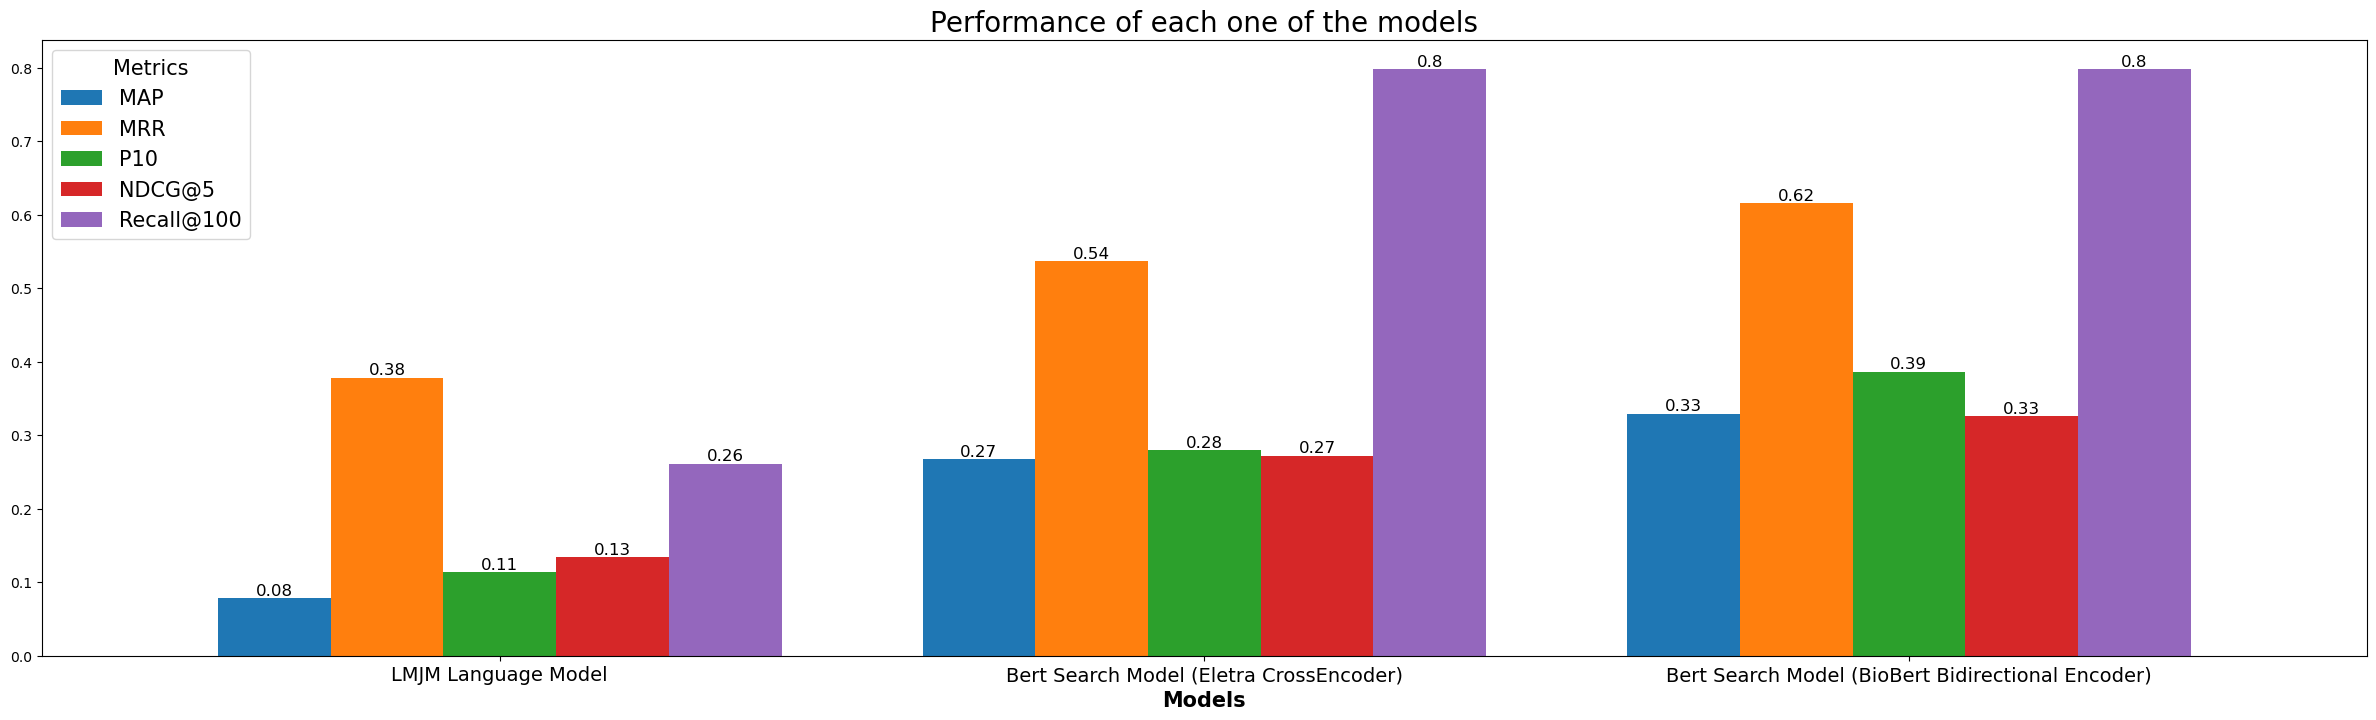

In [18]:
summary = calc_metrics_summary(metrics)
plot_summary_metrics(summary, filename='summary-metrics')

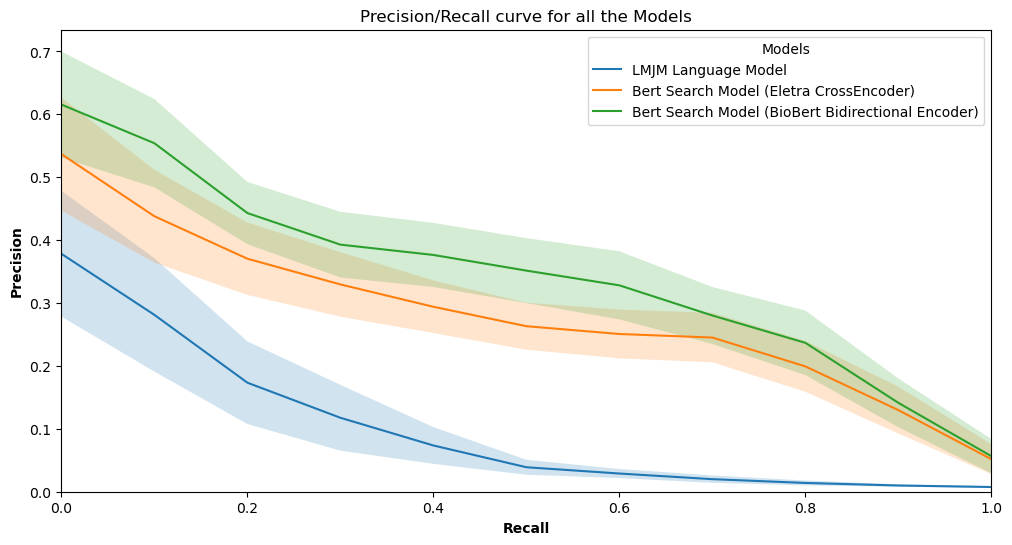

In [19]:
compare_pecision_recall_models(metrics, filename="precision-recall-comparison")